# Fetching and Pre-processing Data

2024-07-04 17:46:26.082082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 17:46:34.554336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 17:46:36.955134: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 79970304 exceeds 10% of free system memory.


Number of Samples: 73257. Sample shape: (32, 32, 3).
X_test Shape: (26032, 32, 32, 3). y_test shape = (26032,)


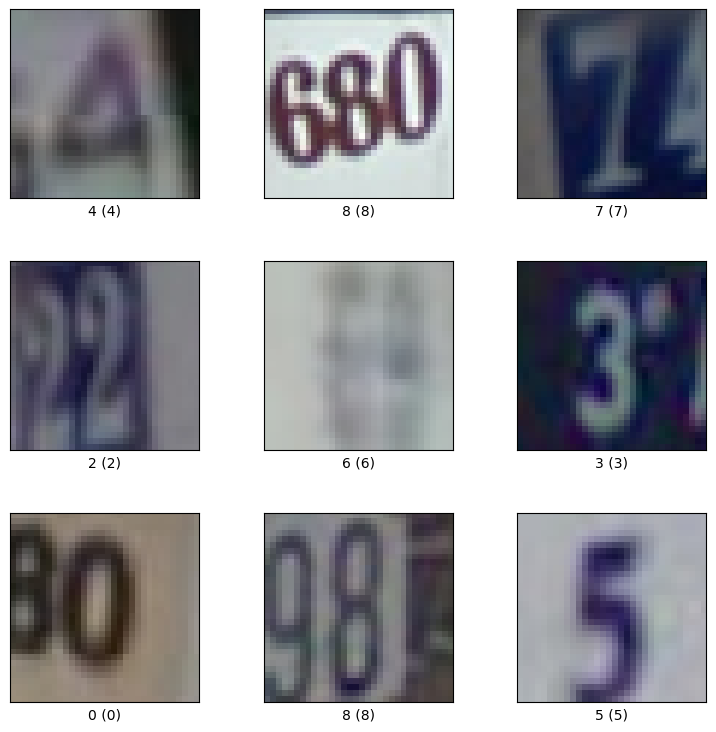

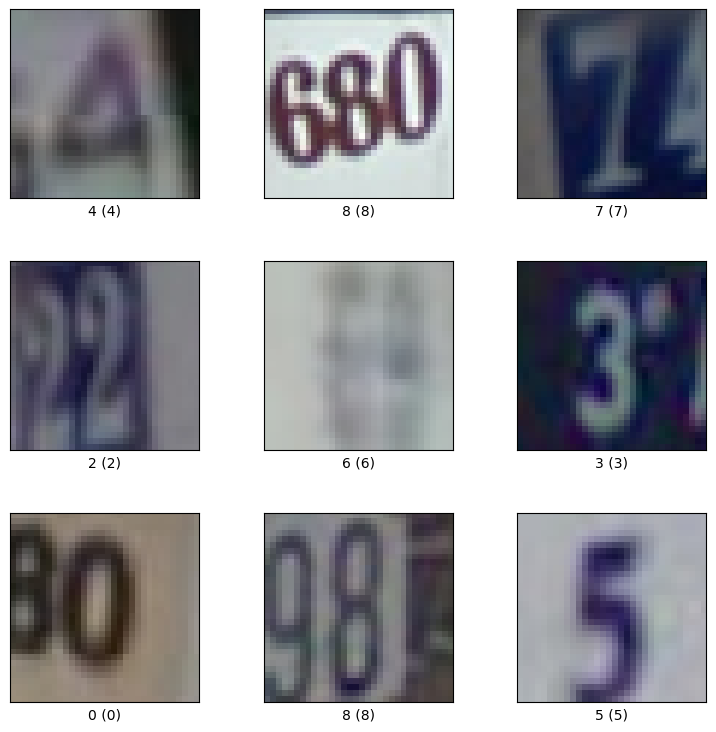

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import numpy as np

ds_train, info = tfds.load('svhn_cropped', split='train[:90%]', shuffle_files=True, with_info=True, as_supervised=True)
ds_val = tfds.load('svhn_cropped', split='train[-10%:]', shuffle_files=True, as_supervised=True)
X_test, y_test = tfds.as_numpy(tfds.load('svhn_cropped', split='test', batch_size=-1, as_supervised=True)) # Load entirety into RAM, Format as numpy float array

train_size = int(info.splits['train'].num_examples)
input_shape = info.features['image'].shape
n_classes = info.features['label'].num_classes

print(f"Number of Samples: {train_size}. Sample shape: {input_shape}.")
print(f"X_test Shape: {X_test.shape}. y_test shape = {y_test.shape}")

tfds.show_examples(ds_train, info)

In [2]:
batch_size = 1024

def preprocess(image, label, nclasses=10): # Get dataset as image and one-hot encoded labels, divided by max RGB
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(tf.squeeze(label), nclasses)
    return image, label

train_data = ds_train.map(preprocess, n_classes)  
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)

val_data = ds_val.map(preprocess, n_classes)
val_data = val_data.batch(batch_size)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)

X_test, y_test = preprocess(X_test, y_test, nclasses=n_classes)

np.save('X_test.npy', X_test[:3000])
np.save('y_test.npy', y_test[:3000])

2024-07-04 17:46:39.635364: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 319881216 exceeds 10% of free system memory.
2024-07-04 17:46:41.077394: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 319881216 exceeds 10% of free system memory.


In [3]:
import gc

del X_test, y_test

gc.collect()

111

# Defining the Model

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dense
from tensorflow.keras.regularizers import l1

from qkeras import QConv2DBatchnorm, QActivation, QDense
from qkeras.autoqkeras.utils import print_qmodel_summary

filters_per_conv_layer = [16, 16, 24]
neurons_per_dense_layer = [42, 64]

x = x_in = Input(shape=input_shape)

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding fused QConv+BN block {} with N={} filters').format(i, f))
    x = QConv2DBatchnorm(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        bias_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True,
        name='fused_convbn_{}'.format(i),
    )(x)
    x = QActivation('quantized_relu(6)', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding QDense block {} with N={} neurons').format(i, n))
    x = QDense(
        n,
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        name='dense_%i' % i,
        use_bias=False,
    )(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = QActivation('quantized_relu(6)', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)
model = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

print_qmodel_summary(model)

Adding fused QConv+BN block 0 with N=16 filters
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Adding fused QConv+BN block 1 with N=16 filters
Adding fused QConv+BN block 2 with N=24 filters
Adding QDense block 0 with N=42 neurons
Adding QDense block 1 with N=64 neurons
fused_convbn_0       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_0           quantized_relu(6)
fused_convbn_1       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_1           quantized_relu(6)
fused_convbn_2       f=24 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_2           quantized_relu(6)
dense_0              u=42 quantized_bits(6,0,0,alpha=1) 
bn_dense_0           is normal keras bn layer
dense_act_0          quantized_relu(6)
dense_1              u=64 quantized_bits(6,0,0,alpha=1) 
bn_dense_1           is normal keras bn layer
dense_act_1          quantized_relu(6)



# Pruning

In [5]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(train_size * 0.9) // batch_size
print(f'Training Steps Per Epoch: {NSTEPS}.')

def pruneFunction(layer): # Prune all layers gradually across 10 epochs
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=0.50,
            begin_step=NSTEPS,
            end_step=NSTEPS * 10,
            frequency=NSTEPS
        )
    }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer


quant_prune_model = tf.keras.models.clone_model(model, clone_function=pruneFunction)

Training Steps Per Epoch: 64.


# Training

In [6]:
import time

train = False

n_epochs = 20

if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    quant_prune_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = quant_prune_model.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks, verbose=1)
    end = time.time()
    print(f"\nTraining time: {(end - start) / 60.0}.")

    quant_prune_model.save('quant_prune_model/model.h5')    

In [7]:
import gc

del model
del quant_prune_model
del x, x_in, x_out

del ds_train, ds_val
del train_data, val_data
del info, train_size, input_shape, n_classes

gc.collect()

13559

# Profiling and Conversion

In [8]:
from qkeras.utils import _add_supported_quantized_objects
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
quant_prune_model = tf.keras.models.load_model('quant_prune_model/model.h5', custom_objects=co)
quant_prune_model = strip_pruning(quant_prune_model)

Layer fused_convbn_0: % of zeros = 0.5
Layer fused_convbn_1: % of zeros = 0.5
Layer fused_convbn_2: % of zeros = 0.5
Layer dense_0: % of zeros = 0.5
Layer bn_dense_0: % of zeros = 0.0
Layer dense_1: % of zeros = 0.5
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0


Text(0.2, 0.38, 'qkeras')

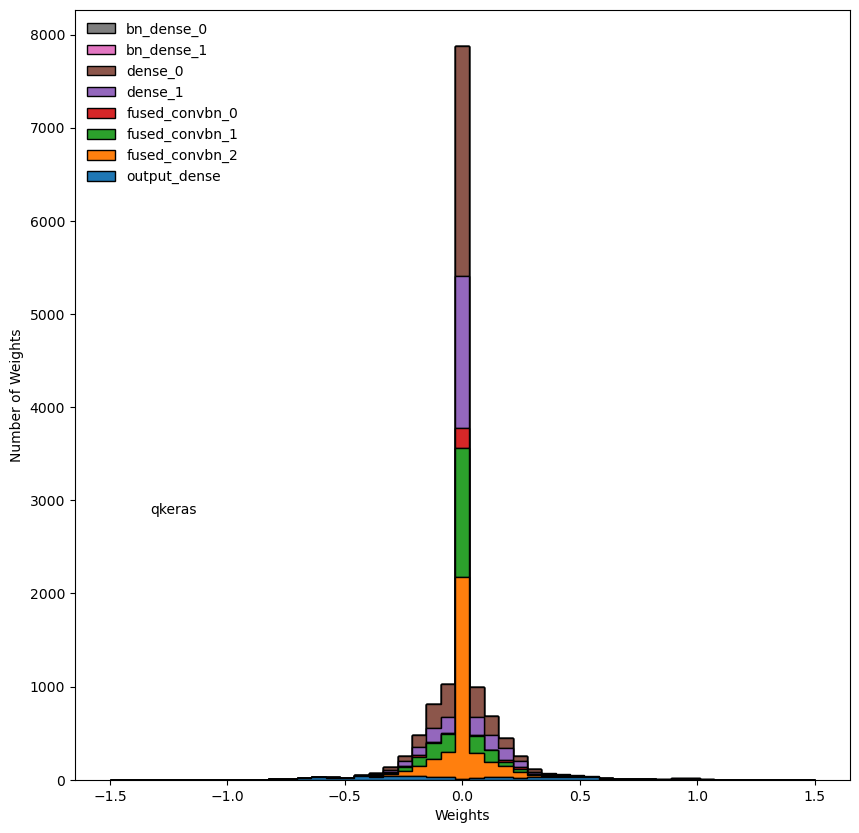

In [9]:
import matplotlib.pyplot as plt

allWeightsByLayer = {}
for layer in quant_prune_model.layers:
    if (layer._name).find("batch") != -1 or len(layer.get_weights()) < 1:
        continue
    weights = layer.weights[0].numpy().flatten()
    allWeightsByLayer[layer._name] = weights
    print('Layer {}: % of zeros = {}'.format(layer._name, np.sum(weights == 0) / np.size(weights)))

labelsW = []
histosW = []

for key in reversed(sorted(allWeightsByLayer.keys())):
    labelsW.append(key)
    histosW.append(allWeightsByLayer[key])

fig = plt.figure(figsize=(10, 10))
bins = np.linspace(-1.5, 1.5, 50)
plt.hist(histosW, bins, histtype='stepfilled', stacked=True, label=labelsW, edgecolor='black')
plt.legend(frameon=False, loc='upper left')
plt.ylabel('Number of Weights')
plt.xlabel('Weights')
plt.figtext(0.2, 0.38, quant_prune_model._name, wrap=True, horizontalalignment='left', verticalalignment='center')

In [10]:
import sys
import os

local_module_dir = os.path.join("/home/jovyan/work/hls4ml") # This should be changed the path of the local modified version of HLS4ML containing Vitis Accel backend
sys.path.insert(0, local_module_dir)

import hls4ml
import plotting

hls_config = hls4ml.utils.config_from_keras_model(quant_prune_model, granularity='name')
hls_config['Model']['ReuseFactor'] = 1
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'

print("-----------------------------------")
plotting.print_dict(hls_config)
print("-----------------------------------")

cfg = hls4ml.converters.create_config(backend='VitisAccelerator')
cfg['KerasModel'] = quant_prune_model
cfg['IOType'] = 'io_stream'
cfg['HLSConfig'] = hls_config
cfg['OutputDir'] = 'vitis_accel_prj'
cfg['AcceleratorConfig'] = {}
cfg['AcceleratorConfig']['Board'] = 'alveo-u55c'
cfg['AcceleratorConfig']['Num_Kernel'] = 4
cfg['AcceleratorConfig']['Num_Thread'] = 8
cfg['AcceleratorConfig']['Batchsize'] = 8192

hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()

/home/jovyan/work/hls4ml/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 32, 32, 3]], output shape: [None, 30, 30, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 30, 30, 16]], output shape: [None, 30, 30, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 30, 30, 16]], output shape: [None, 15, 15, 16]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 15, 15, 16]], output shape: [None, 13, 13, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 13, 13, 16]], output shape: [None, 13, 13, 16]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 6, 6, 16]
Layer name: fused_convbn_2, layer type: QConv2DBatchnorm, input shapes: [[None, 6, 6, 16]], output shape: [None, 4, 4, 24]
Layer name: conv_act_

Done


Writing Accelerator code
Done


Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 32, 32, 3]], output shape: [None, 30, 30, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 30, 30, 16]], output shape: [None, 30, 30, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 30, 30, 16]], output shape: [None, 15, 15, 16]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 15, 15, 16]], output shape: [None, 13, 13, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 13, 13, 16]], output shape: [None, 13, 13, 16]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 6, 6, 16]
Layer name: fused_convbn_2, layer type: QConv2DBatchnorm, input shapes: [[None, 6, 6, 16]], output shape: [None, 4, 4, 24]
Layer name: conv_act_

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

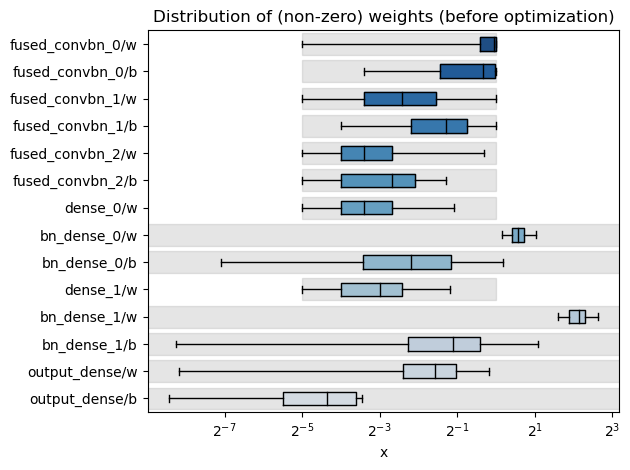

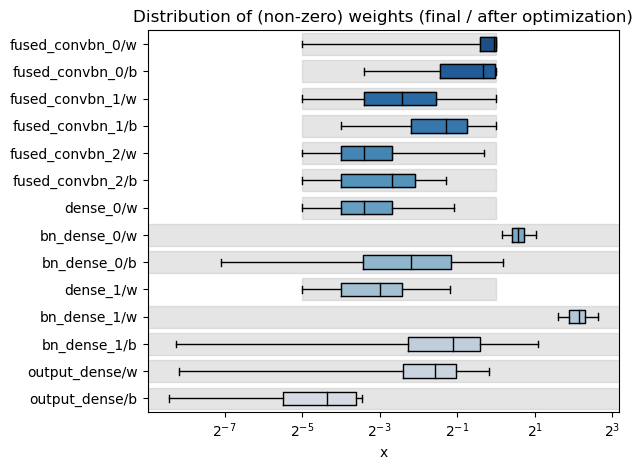

In [11]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)
hls4ml.model.profiling.numerical(model=quant_prune_model, hls_model=hls_model)

In [12]:
from hls4ml.backends.vitis_accelerator.vitis_accelerator_backend import VitisAcceleratorBackend

X_test = np.load("X_test.npy")
y_test = np.load('y_test.npy')

y_keras = quant_prune_model.predict(X_test)
# y_hls_hw = hls_model.hardware_predict(X_test) # Not used because I haven't figured out the set-up yet.
VitisAcceleratorBackend.numpy_to_dat(hls_model.config.backend, hls_model, X_test) # Manually copy tb_input_features.dat after executing this
y_hls_hw = VitisAcceleratorBackend.dat_to_numpy(hls_model.config.backend, hls_model) # Manually copy hw_results.dat before executing this

print(f"Keras Output Data Shape: {y_keras.shape}. HLS Output Data Shape: {y_hls_hw.shape}")

2024-07-04 17:47:25.030565: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 36864000 exceeds 10% of free system memory.


94/94 [==============================] - 2s 13ms/step
Keras Output Data Shape: (3000, 10). HLS Output Data Shape: (3000, 10)


Accuracy Keras: 0.8446666666666667
Accuracy hls4ml: 0.845


(0.7, 1.0)

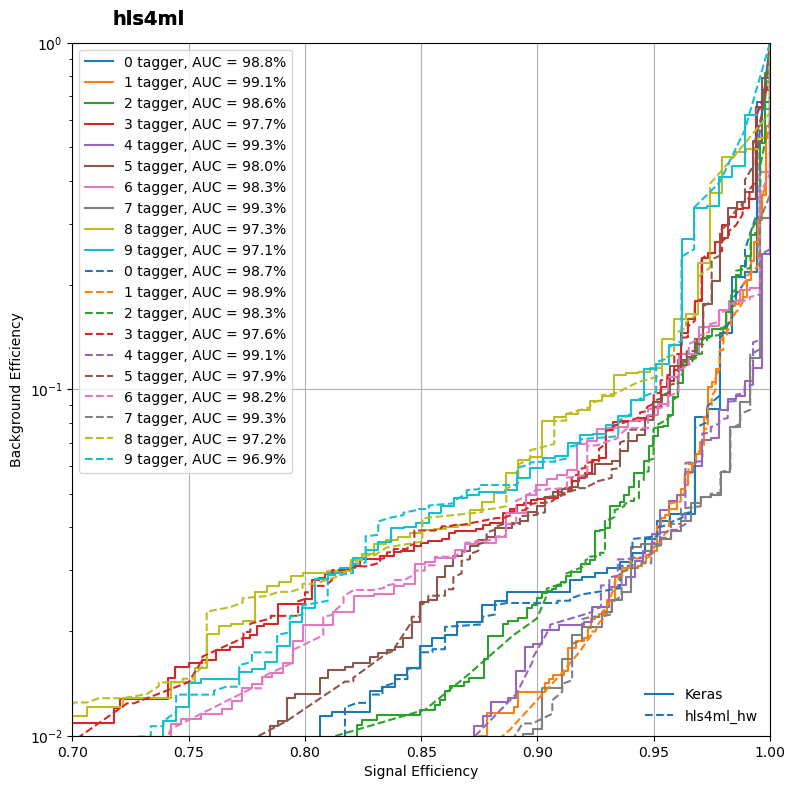

In [13]:
from sklearn.metrics import accuracy_score

from matplotlib.lines import Line2D
from matplotlib.legend import Legend

accuracy_keras = float(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1)))
accuracy_hls4ml = float(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls_hw, axis=1)))

print(f"Accuracy Keras: {accuracy_keras}")
print(f"Accuracy hls4ml: {accuracy_hls4ml}")

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, labels=['%i' % nr for nr in range(10)])
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls_hw, labels=['%i' % nr for nr in range(10)], linestyle='--')

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]

leg = Legend(ax, lines, labels=['Keras', 'hls4ml_hw'], loc='lower right', frameon=False)
ax.add_artist(leg)
plt.ylim(0.01, 1.0)
plt.xlim(0.7, 1.0)